# Phonocardiography Pre-processing

## Import libraries and define functions

In [1]:
import os
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.stats import norm
import pywt
import pydub
from sklearn.preprocessing import OneHotEncoder
import preprocessing_lib as pplib
import feature_extraction_lib as ftelib
import file_process_lib as importlib

## Preprocessing Example for Physionet

In [19]:
# Directory containing the files
directory_signal = r'../Physionet_2016_training/training-a/a0288.wav'
directory_labels = r'../Physionet_2016_labels/training-a-Aut/a0288_StateAns0.mat'

### Load Wav Files

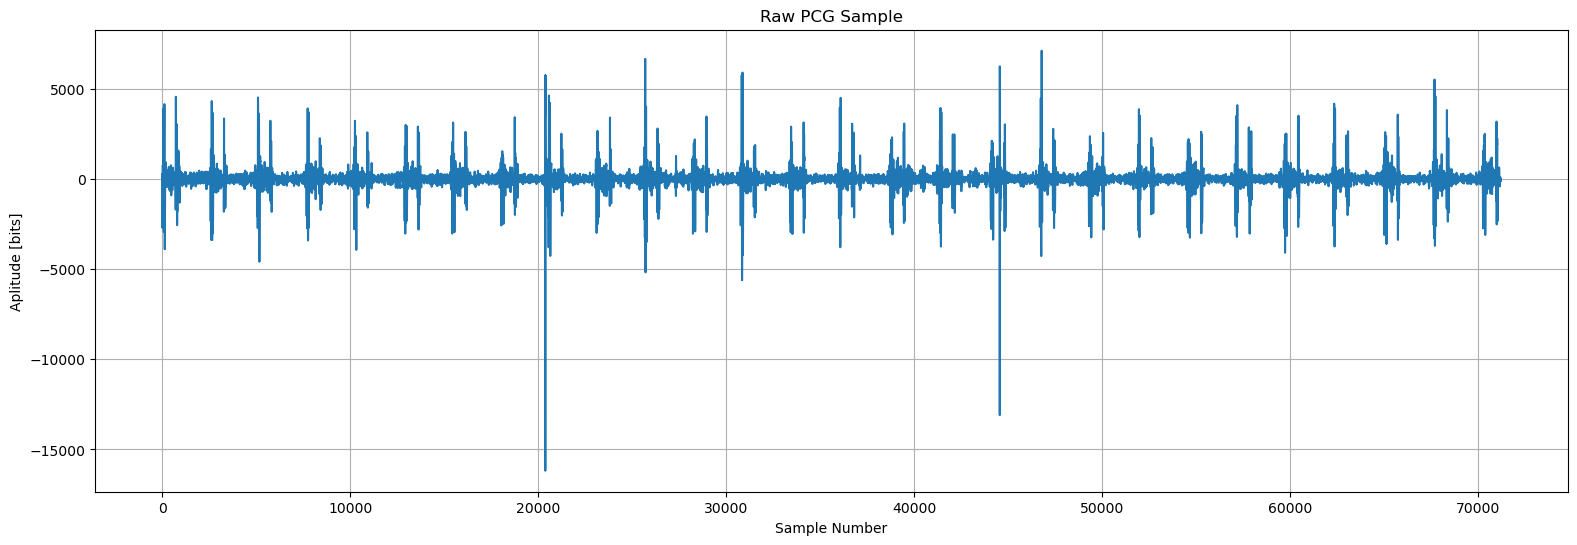

In [20]:
samplerate, original_data, propagated_labels = importlib.import_physionet_2016(directory_signal, directory_labels)

plt.figure(figsize=(19,6))
plt.plot(original_data)
plt.grid()
plt.title("Raw PCG Sample")
plt.xlabel("Sample Number")
plt.ylabel("Aplitude [bits]")
plt.show()

### Standardize acquisition

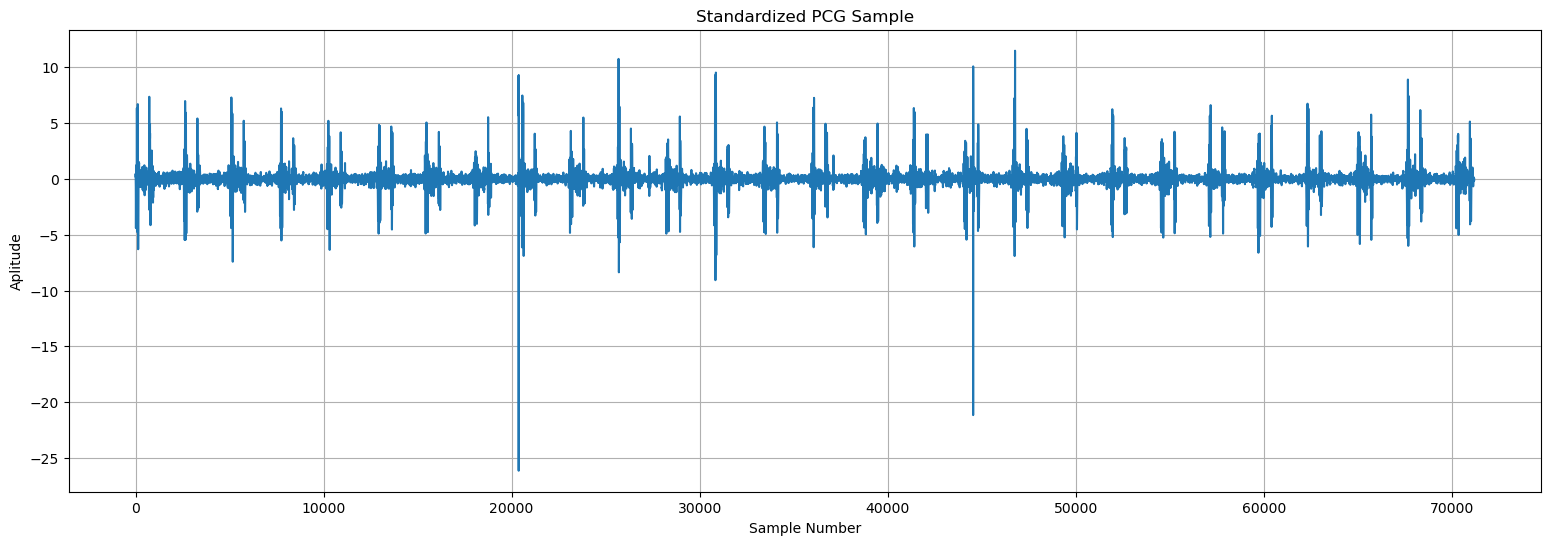

In [21]:
data = np.copy(original_data)
z_norm = pplib.z_score_standardization(data)
plt.figure(figsize=(19,6))
plt.plot(z_norm, label='standardized')
plt.grid()
plt.title("Standardized PCG Sample")
plt.xlabel("Sample Number")
plt.ylabel("Aplitude")
plt.show()

### Denoise

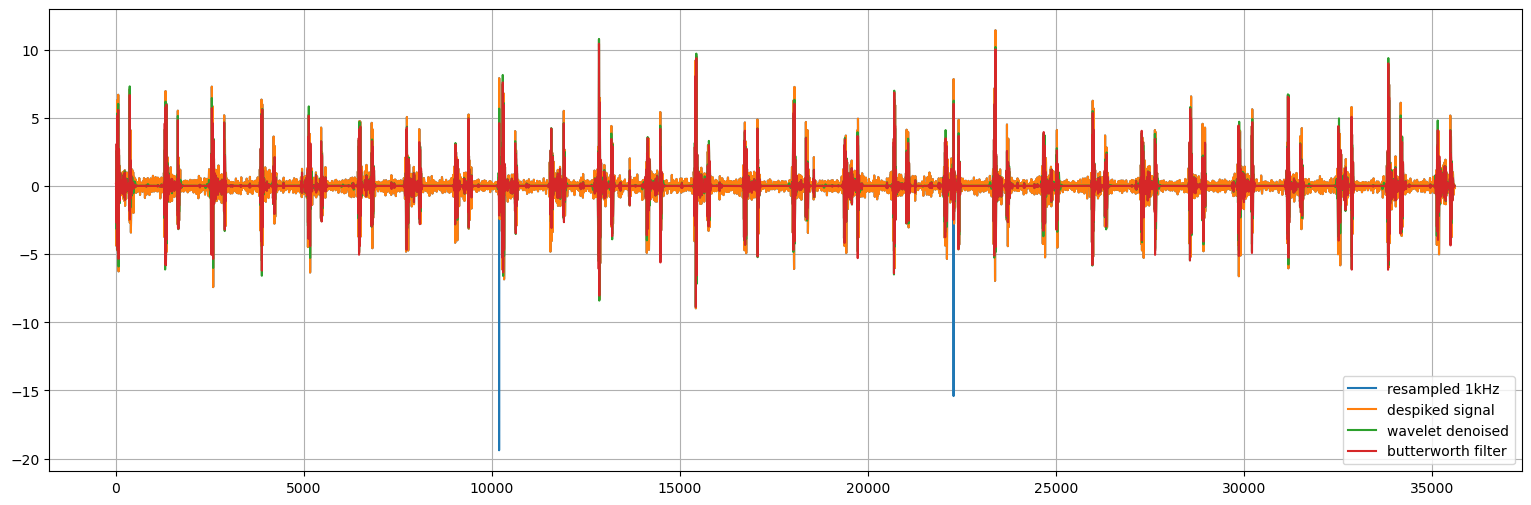

In [ ]:
# resample 1k Hz
plt.figure(figsize=(19,6))
resample = pplib.downsample(z_norm, samplerate, 1000)
plt.plot(resample, label='resampled 1kHz')

# Schmidt despiking
despiked_signal = pplib.schmidt_spike_removal(resample, 1000)
plt.plot(despiked_signal, label='despiked signal')

# wavelet denoising
wavelet_denoised = pplib.wavelet_denoise(despiked_signal, 5, wavelet_family='coif4',
                                         risk_estimator=pplib.val_SURE_threshold,
                                         shutdown_bands=[-1, 1])
plt.plot(wavelet_denoised, label='wavelet denoised')

# butterworth filter
filtered_pcg = pplib.butterworth_filter(wavelet_denoised, 'bandpass', 4, 1000, [25, 400])
plt.plot(filtered_pcg, label='butterworth filter')
plt.grid()
plt.legend(loc='lower right')
plt.show()

### Feature Extraction

Deals with Homomorphic envelope, CWT Envelope using morlet and mexican hat Wavelets, DWT Envelope, and Hilbert Envelope

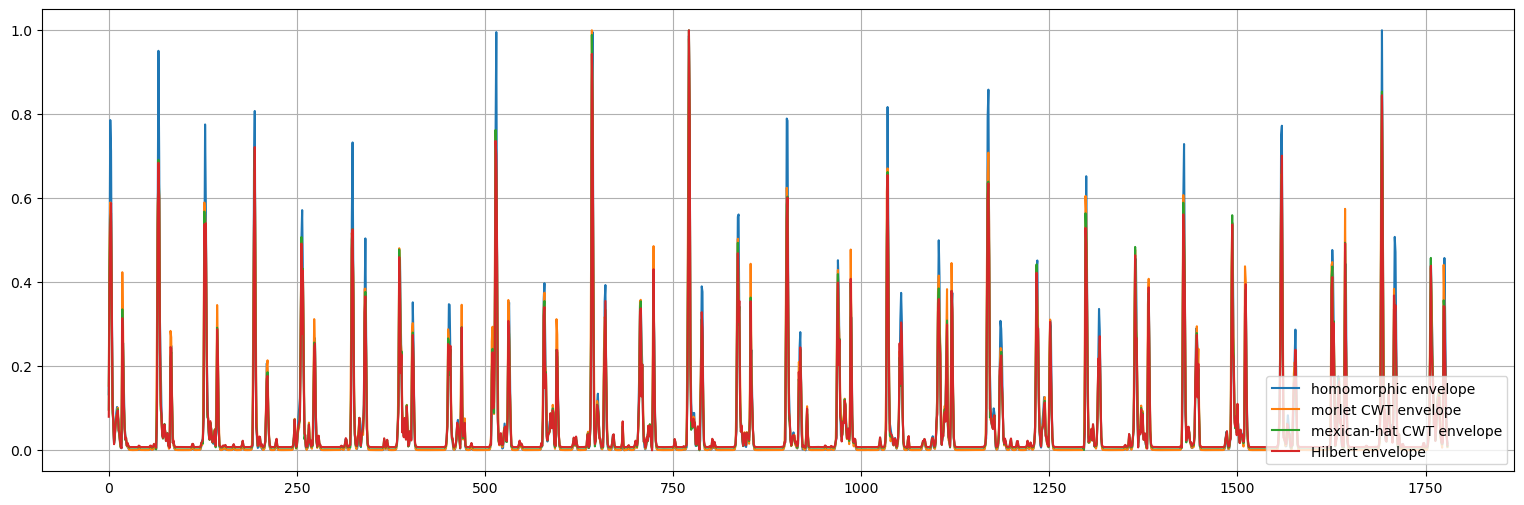

In [24]:
# Homomorphic envelope
plt.figure(figsize=(19,6))
homomorphic = ftelib.homomorphic_envelope(filtered_pcg, 1000, 50)
plt.plot(homomorphic, label='homomorphic envelope')


# Wavelet envelope
cwt_morl = ftelib.c_wavelet_envelope(filtered_pcg, 1000, 50, interest_frequencies=[40, 200])
plt.plot(cwt_morl, label='morlet CWT envelope')

cwt_mexh = ftelib.c_wavelet_envelope(filtered_pcg, 1000, 50, wv_family='mexh', interest_frequencies=[40, 200])
plt.plot(cwt_mexh, label='mexican-hat CWT envelope')


hilbert_env = ftelib.hilbert_envelope(filtered_pcg, 1000, 50)
plt.plot(hilbert_env, label='Hilbert envelope')

plt.grid()
plt.legend(loc='lower right')
plt.show()

### Labels Encoding and Processing

In [7]:
# Label Processing
desired_order = ['S1', 'systole', 'S2', 'diastole']
# Extract the unique labels and reshape the labels for one-hot encoding
unique_labels = np.unique(propagated_labels)
# Ensure that the desired order matches the unique labels
assert set(desired_order) == set(
    unique_labels), "The desired order does not match the unique labels"

# Reshape the labels to a 2D array to fit the OneHotEncoder input
propagated_labels_reshaped = propagated_labels.reshape(-1, 1)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False,
                        categories=[desired_order])

# Fit and transform the labels to one-hot encoding
# one_hot_encoded = np.abs(pplib.downsample(
#     encoder.fit_transform(propagated_labels_reshaped), samplerate, 50))

one_hot_encoded = encoder.fit_transform(propagated_labels_reshaped)
one_hot_encoded = one_hot_encoded[::40, :]

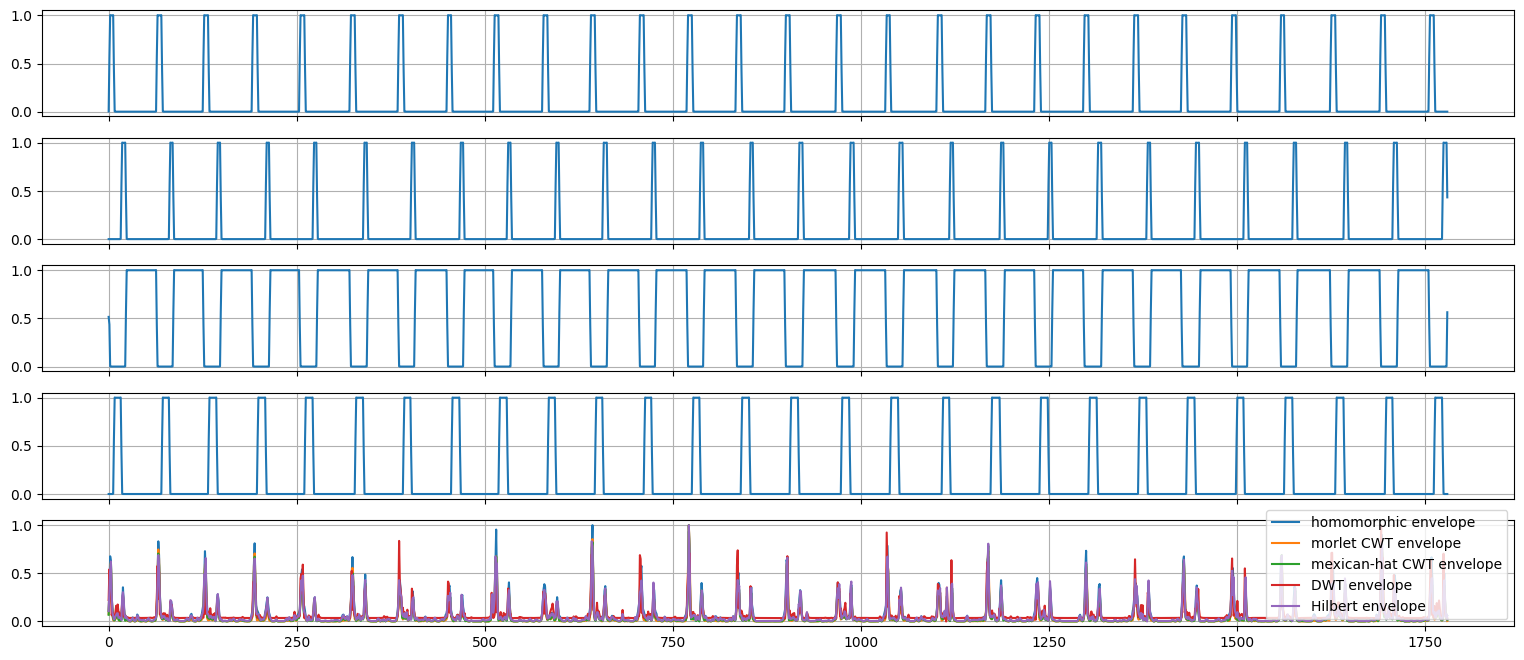

In [ ]:
fig, axs = plt.subplots(5,1, sharex=True, sharey=True)
axs[0].plot(one_hot_encoded[:,0])
axs[0].grid()
axs[1].plot(one_hot_encoded[:,1])
axs[1].grid()
axs[2].plot(one_hot_encoded[:,2])
axs[2].grid()
axs[3].plot(one_hot_encoded[:,3])
axs[3].grid()
axs[4].plot(homomorphic, label='homomorphic envelope')
axs[4].plot(cwt_morl, label='morlet CWT envelope')
axs[4].plot(cwt_mexh, label='mexican-hat CWT envelope')
axs[4].plot(hilbert_env, label='Hilbert envelope')

axs[4].legend(loc="lower right")
axs[4].grid()
fig.set_size_inches(19,8)
plt.show()

## Preprocessing Example for old DatasetCHVNGE

In [37]:
# Directory containing the files
PCG_path = r'../DatasetCHVNGE/12_AV.mp3'

### Import PCG

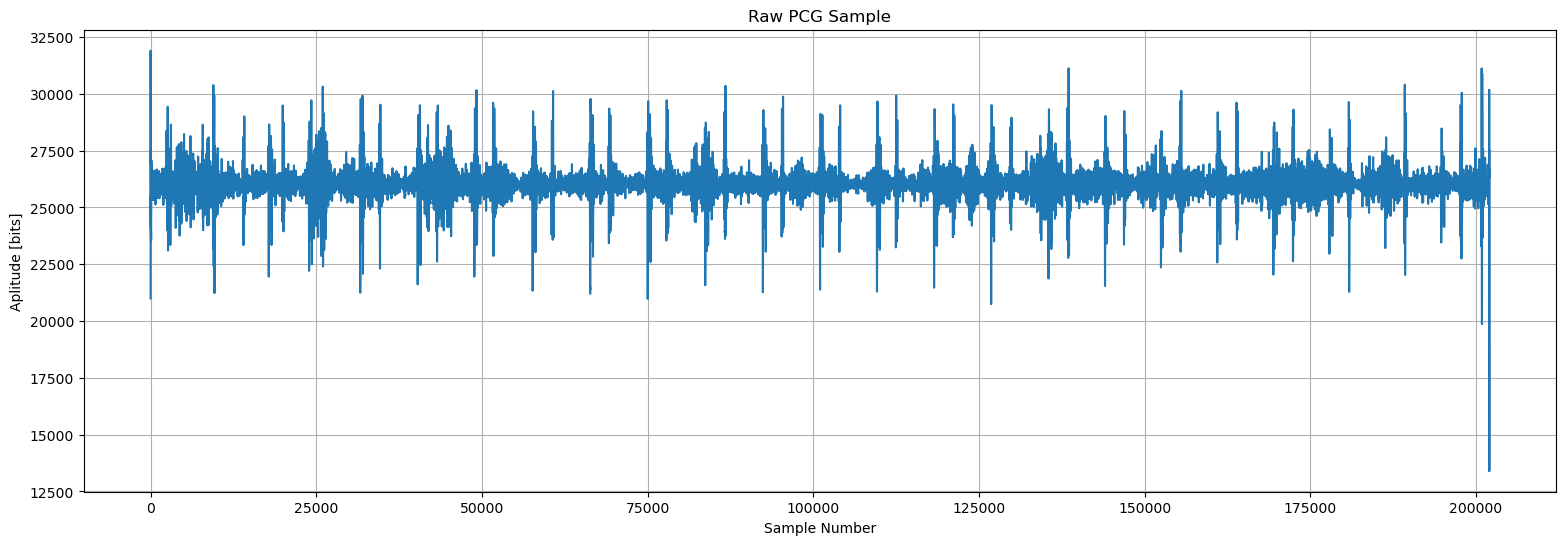

In [38]:
a = pydub.AudioSegment.from_mp3(PCG_path)
PCG_rate = a.frame_rate
t = a.duration_seconds
PCG = np.array(a.get_array_of_samples())
PCG_bit_width = 16
PCG_resolution = (2 ** PCG_bit_width)-1

plt.figure(figsize=(19,6))
plt.plot(PCG)
plt.grid()
plt.title("Raw PCG Sample")
plt.xlabel("Sample Number")
plt.ylabel("Aplitude [bits]")
plt.show()

### Standardize Acquisition

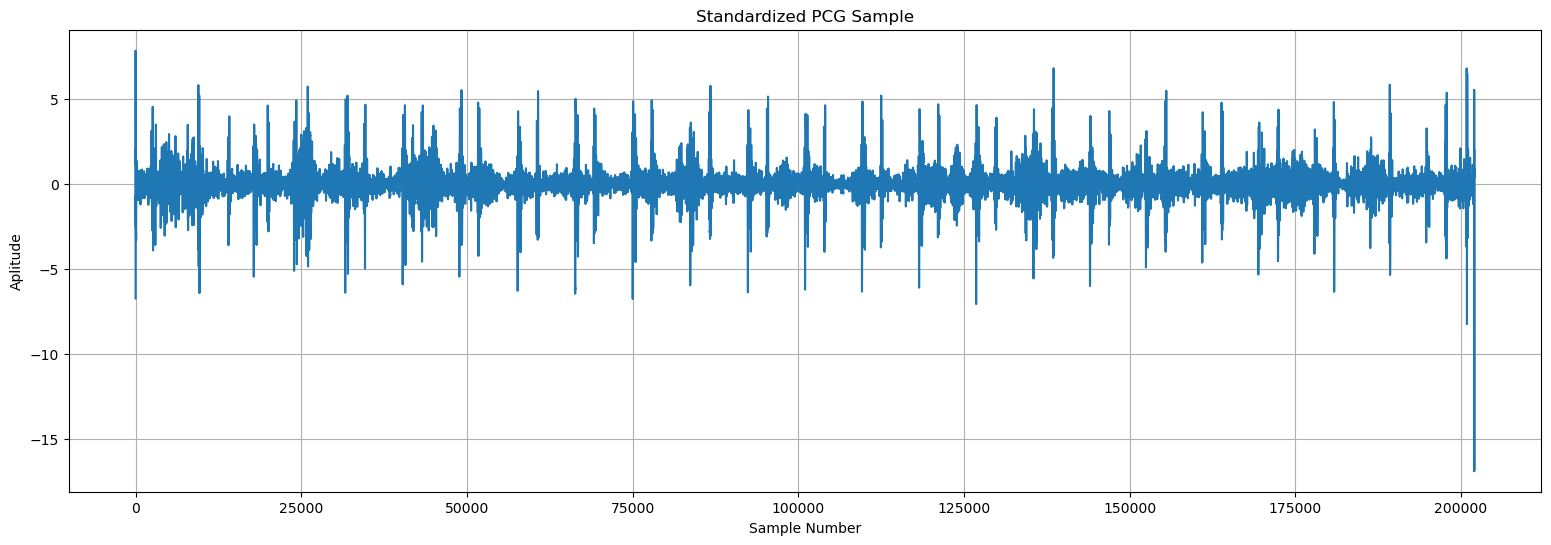

In [39]:
data = np.copy(PCG)
z_norm = pplib.z_score_standardization(data)

plt.figure(figsize=(19,6))
plt.plot(z_norm, label='standardized')
plt.grid()
plt.title("Standardized PCG Sample")
plt.xlabel("Sample Number")
plt.ylabel("Aplitude")
plt.show()

### Denoise

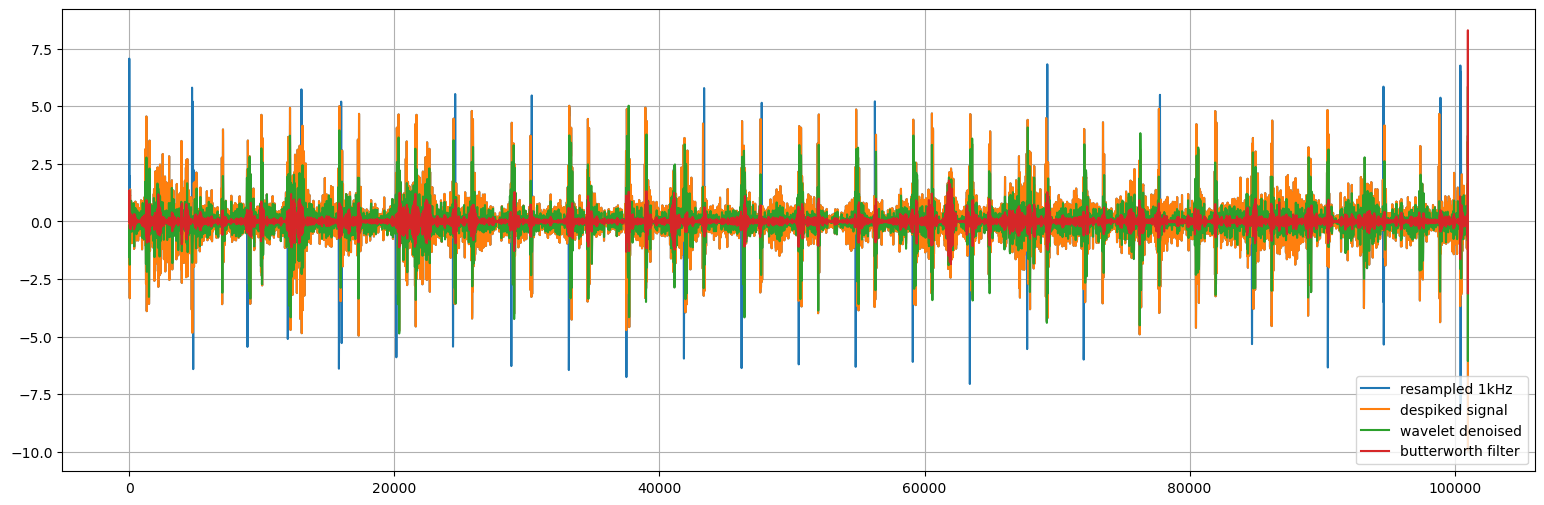

In [47]:
# resample 1k Hz
plt.figure(figsize=(19,6))
resample = pplib.downsample(z_norm, samplerate, 1000)
plt.plot(resample, label='resampled 1kHz')

# Schmidt despiking
despiked_signal = pplib.schmidt_spike_removal(resample, 1000)
plt.plot(despiked_signal, label='despiked signal')

# wavelet denoising
wavelet_denoised = pplib.wavelet_denoise(despiked_signal, 5, wavelet_family='coif4',
                                         risk_estimator=pplib.val_SURE_threshold,
                                         shutdown_bands=[-1, 1,2])
plt.plot(wavelet_denoised, label='wavelet denoised')

# butterworth filter
filtered_pcg = pplib.butterworth_filter(wavelet_denoised, 'bandpass', 4, 1000, [15, 450])
plt.plot(filtered_pcg, label='butterworth filter')
plt.grid()
plt.legend(loc='lower right')
plt.show()

### Feature Extraction

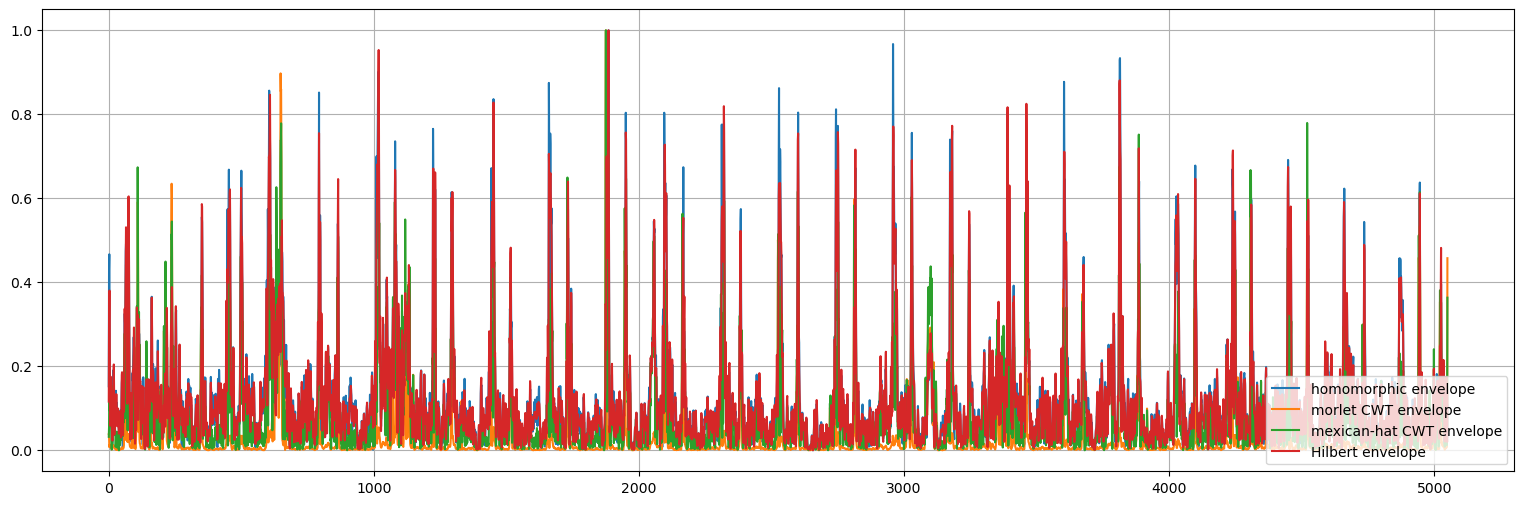

In [42]:
# Homomorphic envelope
plt.figure(figsize=(19,6))
homomorphic = ftelib.homomorphic_envelope(wavelet_denoised, 1000, 50)
plt.plot(homomorphic, label='homomorphic envelope')


# Wavelet envelope
cwt_morl = ftelib.c_wavelet_envelope(wavelet_denoised, 1000, 50, interest_frequencies=[40, 60])
plt.plot(cwt_morl, label='morlet CWT envelope')

cwt_mexh = ftelib.c_wavelet_envelope(wavelet_denoised, 1000, 50, wv_family='mexh', interest_frequencies=[40, 60])
plt.plot(cwt_mexh, label='mexican-hat CWT envelope')

hilbert_env = ftelib.hilbert_envelope(wavelet_denoised, 1000, 50)
plt.plot(hilbert_env, label='Hilbert envelope')

plt.grid()
plt.legend(loc='lower right')
plt.show()

### Expanded View of them

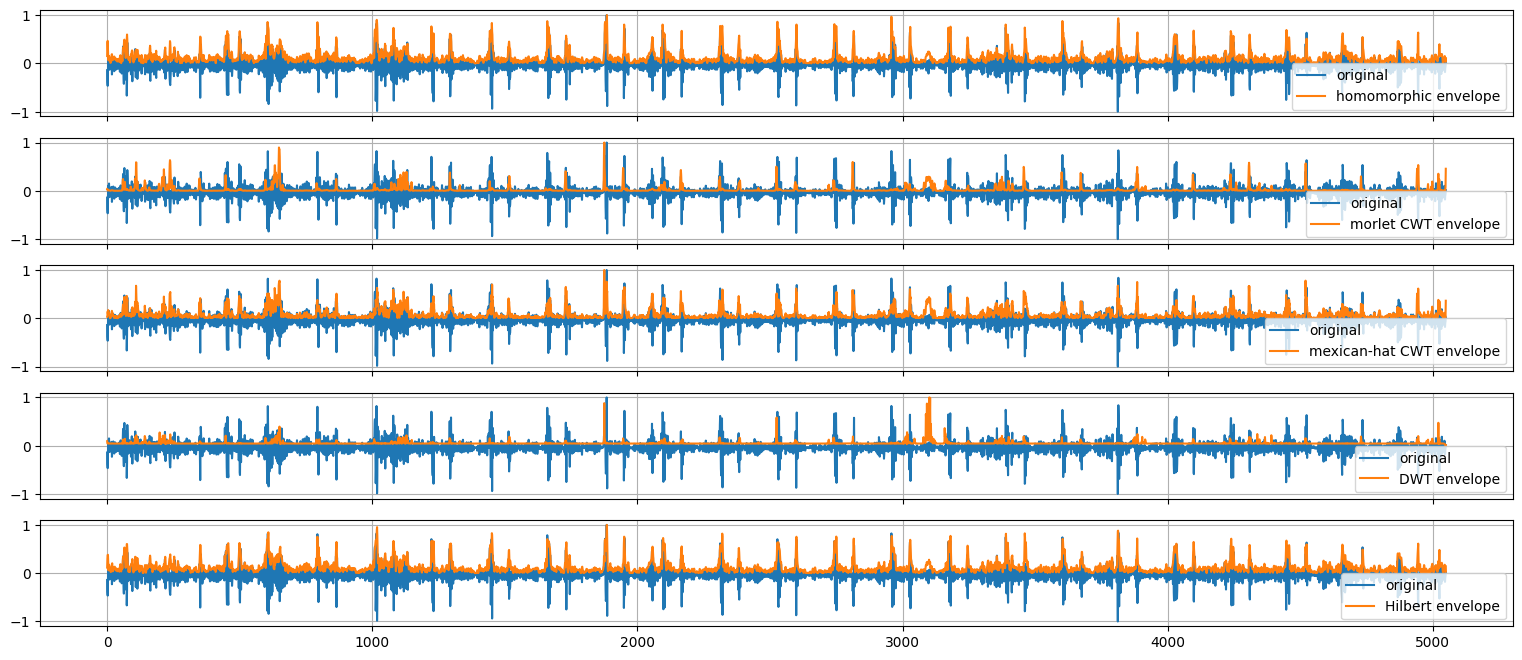

In [32]:
fig, axs = plt.subplots(5,1, sharex=True, sharey=False)
axs[0].plot(pplib.min_max_norm2(pplib.downsample(wavelet_denoised, 1000, 50)), label='original')
axs[0].plot(homomorphic, label='homomorphic envelope')
axs[0].legend(loc="lower right")
axs[0].grid()

axs[1].plot(pplib.min_max_norm2(pplib.downsample(wavelet_denoised, 1000, 50)), label='original')
axs[1].plot(cwt_morl, label='morlet CWT envelope')
axs[1].legend(loc="lower right")
axs[1].grid()

axs[2].plot(pplib.min_max_norm2(pplib.downsample(wavelet_denoised, 1000, 50)), label='original')
axs[2].plot(cwt_mexh, label='mexican-hat CWT envelope')
axs[2].legend(loc="lower right")
axs[2].grid()

axs[3].plot(pplib.min_max_norm2(pplib.downsample(wavelet_denoised, 1000, 50)), label='original')
axs[3].plot(dwt, label='DWT envelope')
axs[3].legend(loc="lower right")
axs[3].grid()

axs[4].plot(pplib.min_max_norm2(pplib.downsample(wavelet_denoised, 1000, 50)), label='original')
axs[4].plot(hilbert_env, label='Hilbert envelope')
axs[4].legend(loc="lower right")
axs[4].grid()

fig.set_size_inches(19,8)
plt.show()